FE_520 Credit Card Fault Detection 

In [99]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [86]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

In [30]:
# Read file into dataframe and print out dataframe shapef
df = pd.read_csv("Credit_Card.csv")


In [31]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [32]:
df.shape

(30000, 25)

In [33]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [34]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [35]:
df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)

In [36]:
missing_percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)

In [37]:
missing_percentage

default.payment.next.month    0.0
PAY_6                         0.0
LIMIT_BAL                     0.0
SEX                           0.0
EDUCATION                     0.0
MARRIAGE                      0.0
AGE                           0.0
PAY_0                         0.0
PAY_2                         0.0
PAY_3                         0.0
PAY_4                         0.0
PAY_5                         0.0
BILL_AMT1                     0.0
PAY_AMT6                      0.0
BILL_AMT2                     0.0
BILL_AMT3                     0.0
BILL_AMT4                     0.0
BILL_AMT5                     0.0
BILL_AMT6                     0.0
PAY_AMT1                      0.0
PAY_AMT2                      0.0
PAY_AMT3                      0.0
PAY_AMT4                      0.0
PAY_AMT5                      0.0
ID                            0.0
dtype: float64

In [38]:
condition = bool(df.duplicated(subset = 'ID').any())

if condition:
    print('There are duplicate IDs')
else:
    print('No duplicate IDs')

No duplicate IDs


In [39]:
pay = df[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']]
pay_melt = pd.melt(pay)
print(pay_melt['value'].value_counts())

 0    95919
-1    34640
-2    24415
 2    18964
 1     3722
 3     1430
 4      453
 7      218
 5      137
 6       74
 8       28
Name: value, dtype: int64


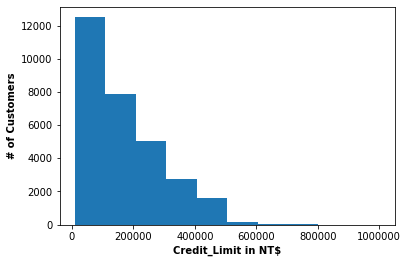

In [40]:
plt.hist(df["LIMIT_BAL"])
plt.xlabel('Credit_Limit in NT$', fontweight='bold')
plt.ylabel('# of Customers', fontweight='bold')
plt.show()


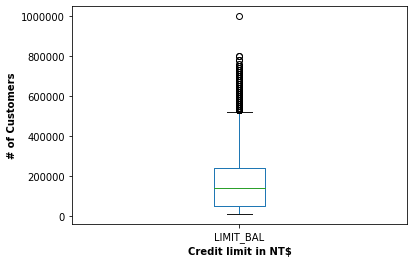

In [41]:
df["LIMIT_BAL"].plot(kind="box")
plt.xlabel('Credit limit in NT$', fontweight='bold')
plt.ylabel('# of Customers', fontweight='bold')
plt.show()

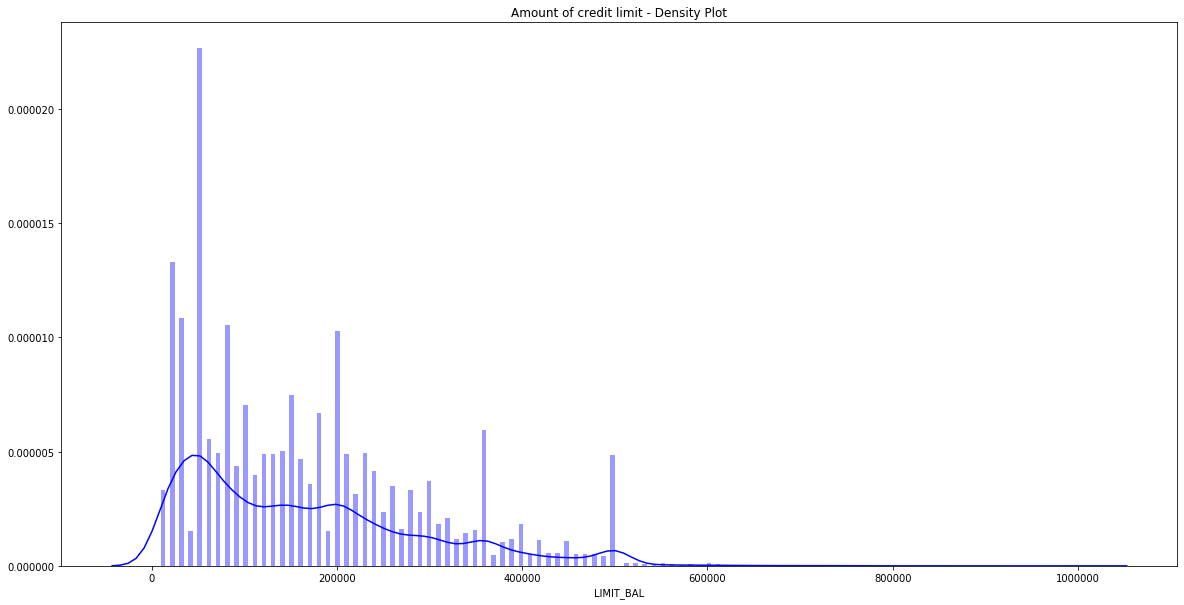

In [42]:
plt.figure(figsize = (20,10))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(df['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()
# Use histogram to view the distribution of credit limit

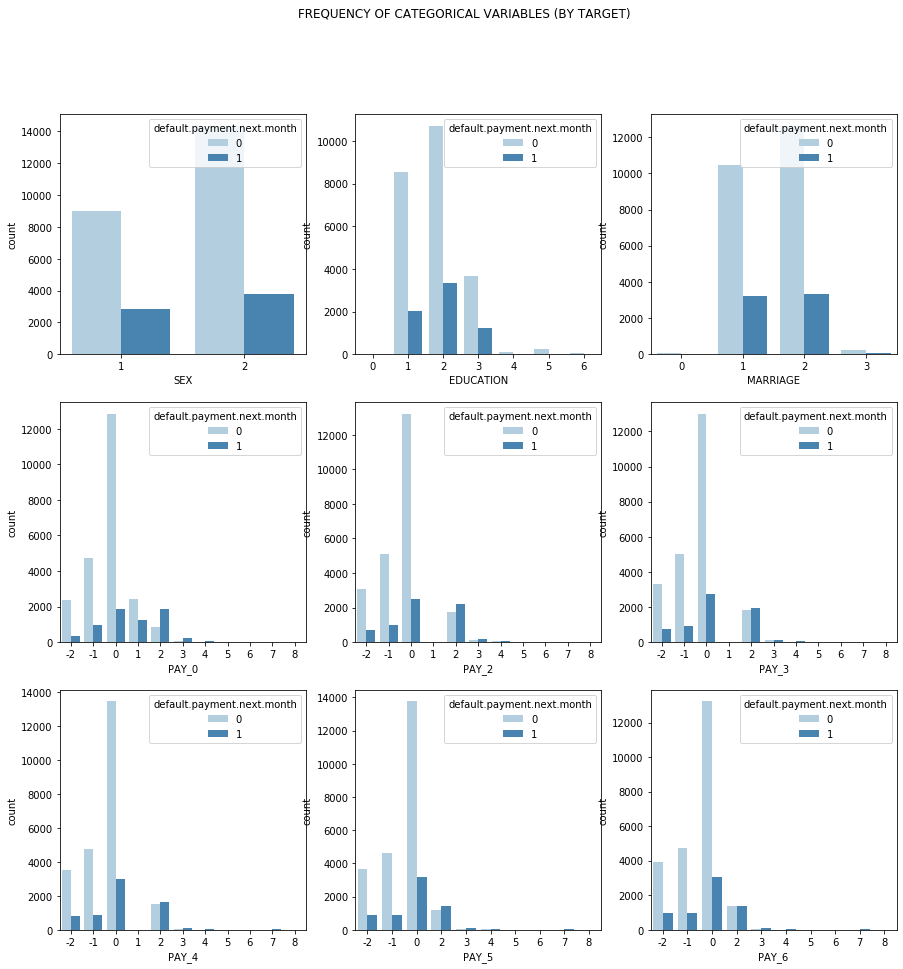

In [100]:
subset = df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 
               'PAY_5', 'PAY_6', 'default.payment.next.month']]

f, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')
ax1 = sns.countplot(x="SEX", hue="default.payment.next.month", data=subset, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="EDUCATION", hue="default.payment.next.month", data=subset, palette="Blues",ax=axes[0,1])
ax3 = sns.countplot(x="MARRIAGE", hue="default.payment.next.month", data=subset, palette="Blues",ax=axes[0,2])
ax4 = sns.countplot(x="PAY_0", hue="default.payment.next.month", data=subset, palette="Blues", ax=axes[1,0])
ax5 = sns.countplot(x="PAY_2", hue="default.payment.next.month", data=subset, palette="Blues", ax=axes[1,1])
ax6 = sns.countplot(x="PAY_3", hue="default.payment.next.month", data=subset, palette="Blues", ax=axes[1,2])
ax7 = sns.countplot(x="PAY_4", hue="default.payment.next.month", data=subset, palette="Blues", ax=axes[2,0])
ax8 = sns.countplot(x="PAY_5", hue="default.payment.next.month", data=subset, palette="Blues", ax=axes[2,1])
ax9 = sns.countplot(x="PAY_6", hue="default.payment.next.month", data=subset, palette="Blues", ax=axes[2,2]);

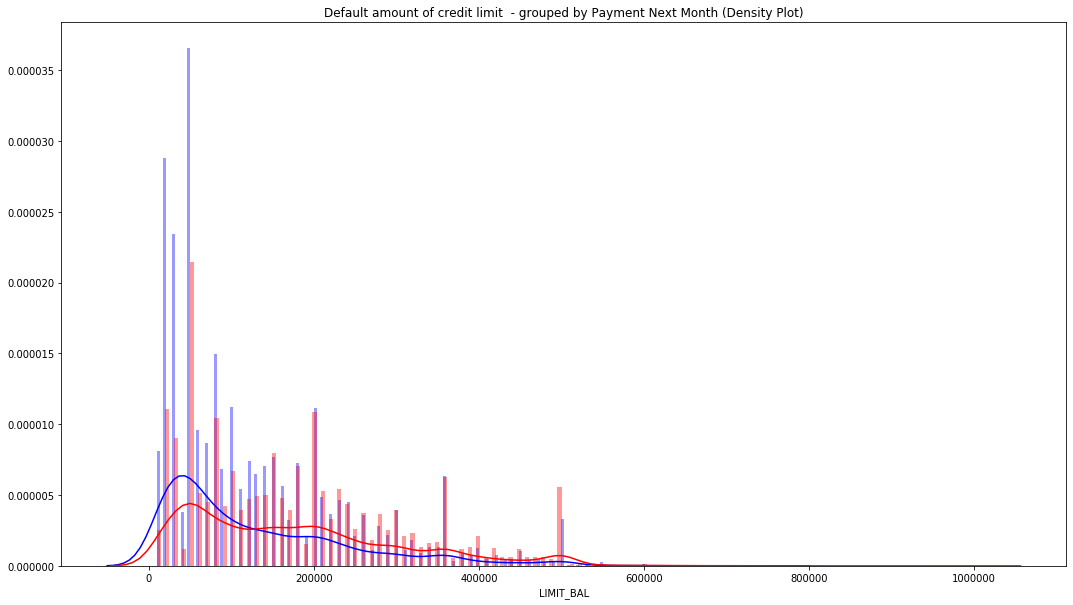

In [104]:
class_0 = df.loc[df['default.payment.next.month'] == 0]["LIMIT_BAL"]
class_1 = df.loc[df['default.payment.next.month'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (18,10))
plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="blue")
sns.distplot(class_0,kde=True,bins=200, color="red")
plt.show()

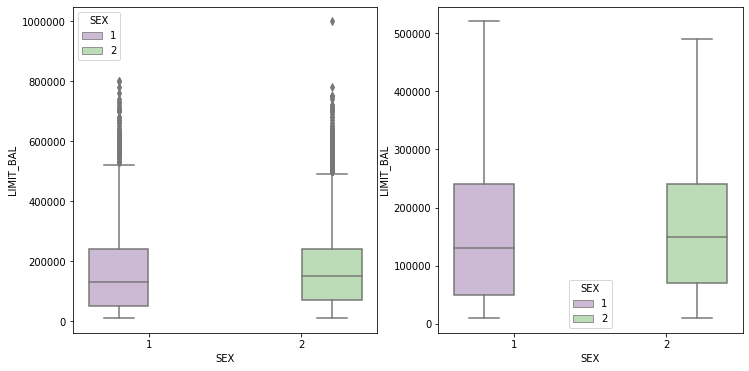

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="SEX", y="LIMIT_BAL", hue="SEX",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="SEX", y="LIMIT_BAL", hue="SEX",data=df, palette="PRGn",showfliers=False)
plt.show();

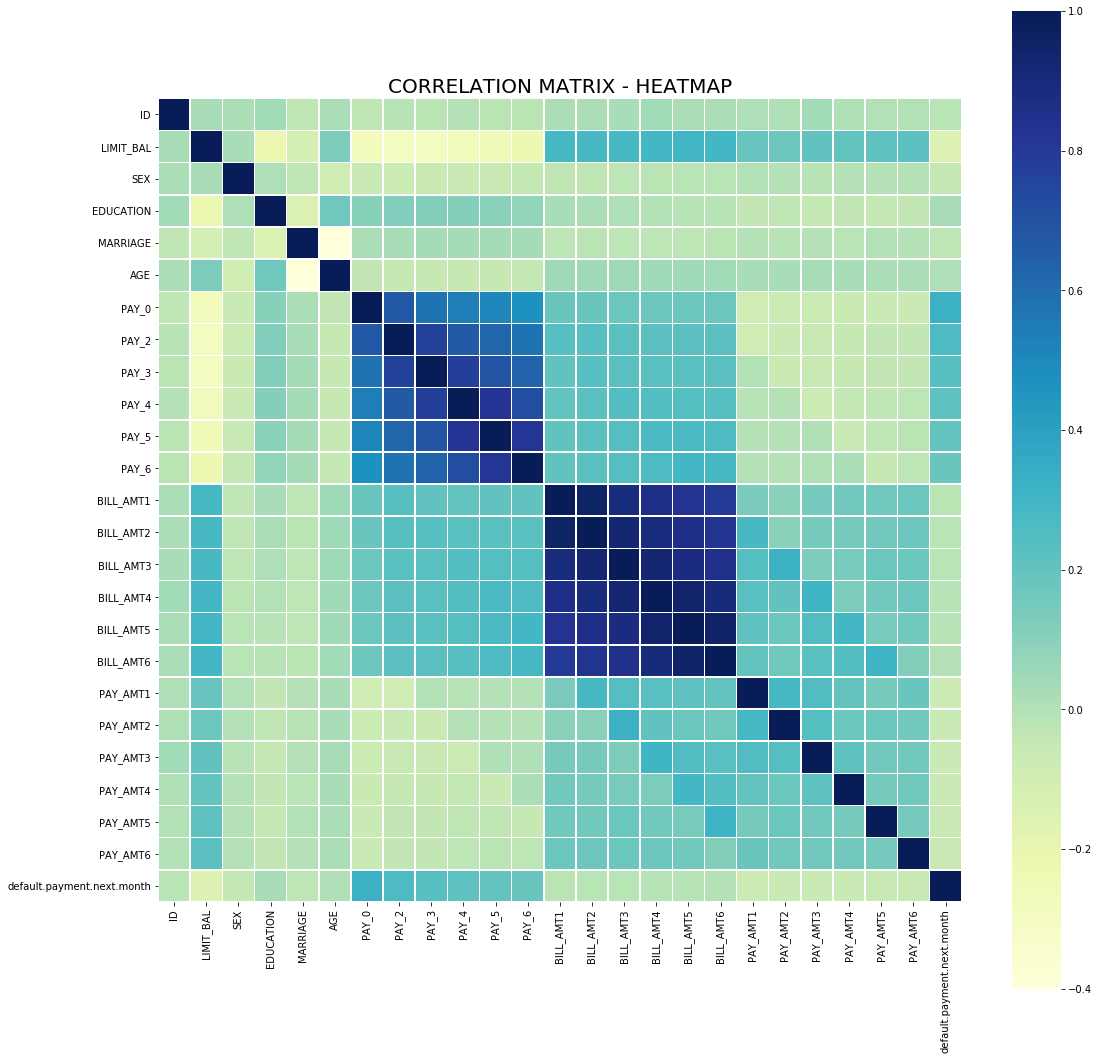

In [103]:
# df.corr()
corr = df.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="YlGnBu", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=20);

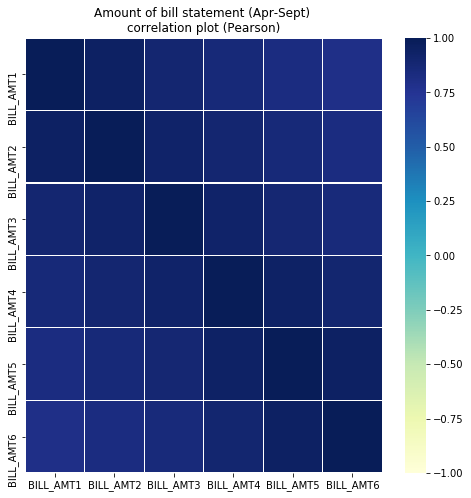

In [71]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,cmap="YlGnBu")
plt.show()

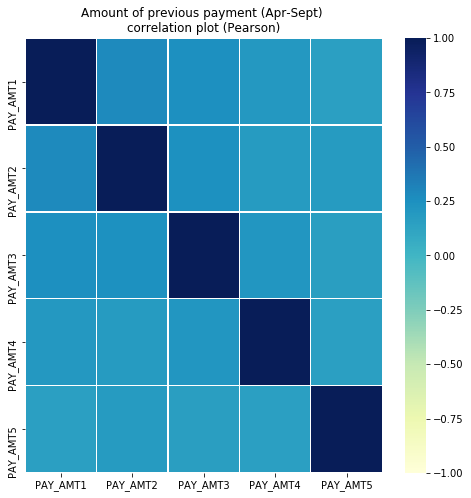

In [72]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,cmap="YlGnBu")
plt.show()

In [73]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [77]:
train_df, val_df = train_test_split(df, shuffle=True )

In [78]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

In [80]:
clf = RandomForestClassifier()

In [81]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier()

In [82]:
preds = clf.predict(val_df[predictors])

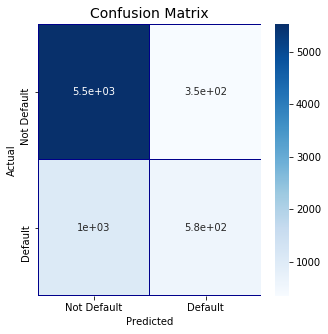

In [83]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [84]:
roc_auc_score(val_df[target].values, preds)

0.6481478723355159

In [87]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [88]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[18:02:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69507	valid-auc:0.68740
[50]	train-auc:0.76872	valid-auc:0.76661
[100]	train-auc:0.77674	valid-auc:0.77540
[150]	train-auc:0.78230	valid-auc:0.78049
[200]	train-auc:0.78599	valid-auc:0.78314
[250]	train-auc:0.78892	valid-auc:0.78502
[300]	train-auc:0.79156	valid-auc:0.78606
[350]	train-auc:0.79384	valid-auc:0.78661
[400]	train-auc:0.79590	valid-auc:0.78714
[450]	train-auc:0.79788	valid-auc:0.78736
[468]	train-auc:0.79857	valid-auc:0.78739


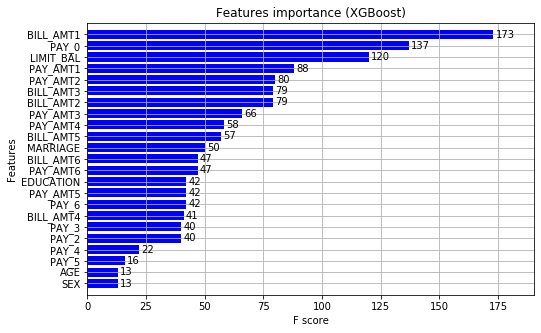

In [90]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="blue") 
plt.show()

In [92]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
train_df, val_df = train_test_split(df, shuffle=True )
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()


In [93]:
clf = KNeighborsClassifier()
clf.fit(train_df[predictors], train_df[target].values)


KNeighborsClassifier()

In [94]:
preds = clf.predict(val_df[predictors])

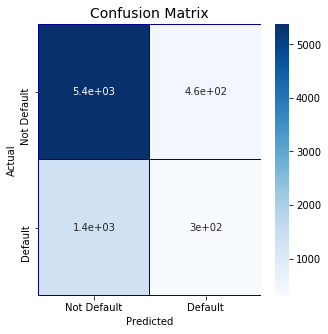

In [95]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [96]:
roc_auc_score(val_df[target].values, preds)

0.5518875611207386